------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.6.9


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
import nltk
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import wget

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# # download sentiment lexicon
# sentiment = wget.download('https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05.js')
# # download review data
# reviews = wget.download('https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json')

# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

/bin/bash: wget: command not found
/bin/bash: wget: command not found


**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')
  
def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c)) 
print("Number of word tokens:", sum(c.values()))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

In [ ]:
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))

         , :    77842
       the :    75948
         . :    59027
         a :    37583
       and :    35235
        of :    33864
        to :    31601
        is :    25972
        in :    21563
        's :    18043
        it :    15904
      that :    15820
     -rrb- :    11768
     -lrb- :    11670
        as :    11312
      with :    10739
       for :     9816
       his :     9542
      this :     9497
      film :     9404


# Lexicon-based approach (2+1pts)



A traditional approach to automatically classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative) or a sentiment score (e.g., a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005). The path of the loaded lexicon is `"sent_lexicon"`.

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon.


Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon.

In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Given such a sentiment lexicon, there are ways to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    sentiment_lexicon = f.readlines()

def strings_to_list(lst): 
    return [[el] for el in lst] 

sentiment_lexicon = strings_to_list(sentiment_lexicon) 

In [ ]:
#Convert sentiment lexicon dictionary to dataframe
sentiment_df = pd.DataFrame(0, index=np.arange(0, len(sentiment_lexicon)), columns=['type', 'len', 'word1', 'pos1', 'stemmed1', 'priorpolarity'])
for i in range(0,len(sentiment_lexicon)): 
        all_words = [words for segments in sentiment_lexicon[i] for words in segments.split('=')]
        all_words = [words for segments in all_words for words in segments.split()]
        all_words = (all_words[1:][::2])
        sentiment_df['type'].iloc[i] = all_words[0] 
        sentiment_df['len'].iloc[i] = all_words[1]
        sentiment_df['word1'].iloc[i] = all_words[2]
        sentiment_df['pos1'].iloc[i] = all_words[3]
        sentiment_df['stemmed1'].iloc[i] = all_words[4]
        sentiment_df['priorpolarity'].iloc[i] = all_words[5]

/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#Since words can have different sentiment classifications depending on their pos1 classifications - for each word the majority polarity is taken
word_polarity = pd.DataFrame(sentiment_df[['word1', 'priorpolarity', 'type', 'pos1']].groupby(['word1', 'priorpolarity']).size().reset_index())
word_polarity['positive'] = np.where(word_polarity['priorpolarity']=='positive',word_polarity.iloc[:,2] , 0)
word_polarity['negative'] = np.where(word_polarity['priorpolarity']=='negative',word_polarity.iloc[:,2] , 0)
word_polarity = word_polarity.groupby(['word1']).agg({'positive': 'sum', 'negative': 'sum'}).reset_index()
#Classify polarity by majority - if equal amount of positive and negative sentiments for one word then classify as neutral
word_polarity['priorpolarity'] = np.where(word_polarity['positive']>word_polarity['negative'],'positive' ,
                                          np.where(word_polarity['positive']<word_polarity['negative'], 'negative', 
                                          'neutral'))

In [ ]:
pos_neg_df = pd.DataFrame(0, index=np.arange(0, len(reviews)), columns=['number_pos', 'number_neg'])

In [ ]:
#'pos_neg_df' df sums up the number of positive and negative words per review (neutral words not considered) 
import itertools
for i in range(0,len(reviews)):
    list_inputs = reviews[i]['content']
    list_inputs_2 = list(itertools.chain(*list_inputs))
    list_final = list(itertools.chain(*list_inputs_2))
    list_final = list_final[::2] 
    list_final = [x.lower() for x in list_final]
    final_words = pd.DataFrame(list_final, columns=['words'])
    merged_final_words = pd.merge(left=final_words, right=word_polarity, how='left', left_on='words', right_on='word1')
    pos_neg_df['number_pos'].iloc[i] = (merged_final_words['priorpolarity'] == 'positive').sum()
    pos_neg_df['number_neg'].iloc[i] = (merged_final_words['priorpolarity'] == 'negative').sum()

In [ ]:
#Total number of positive and negative words over all reviews calculated (-> used in Q1.3)
total_pos_words = pos_neg_df['number_pos'].sum()
total_neg_words = pos_neg_df['number_neg'].sum()

In [ ]:
def sentiment_lexicon(pos_neg_df): 
    #Taking into account that there are more positive than negative words
    pos_neg_df['number_pos'] = pos_neg_df['number_pos']-8
    pos_neg_df['classification'] = '0'
    pos_neg_df.loc[pos_neg_df['number_pos'] > pos_neg_df['number_neg'], 'classification'] = 'POS'
    pos_neg_df.loc[pos_neg_df['number_pos'] < pos_neg_df['number_neg'], 'classification'] = 'NEG'
    pos_neg_df['review_sentiment'] = '0'
    for i in range(0,len(reviews)):
        pos_neg_df['review_sentiment'].iloc[i] = reviews[i]['sentiment']
        
    pos_neg_df['classification_accuracy'] = np.where(pos_neg_df['classification']==pos_neg_df['review_sentiment'], 
                                                 1, 0)
    final_data_frame = pos_neg_df
    return final_data_frame

In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
df_results = sentiment_lexicon(pos_neg_df)
token_results = df_results['classification_accuracy']
token_accuracy = token_results.sum()/len(reviews)
print("Accuracy: %0.2f" % token_accuracy)

/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Accuracy: 0.67


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [ ]:
word_polarity['word_polarity'] = word_polarity['word1'] + word_polarity['priorpolarity']

In [ ]:
#Determine word type dependent if the word was earlier defined as positive or negative
#If the word had a majority of positive sentiments in Q1.1 then the word types of only the positive sentiments are counted together
sentiment_df['word_polarity'] = sentiment_df['word1'] + sentiment_df['priorpolarity']
polarity_type = sentiment_df[sentiment_df['word_polarity'].isin(word_polarity['word_polarity'])]

In [ ]:
word_type = pd.DataFrame(polarity_type[['word1', 'priorpolarity', 'type', 'word_polarity']].groupby(['word1', 'type']).size().reset_index())

In [ ]:
word_type['weaksubj'] = np.where(word_type['type']=='weaksubj',word_type.iloc[:,2] , 0)
word_type['strongsubj'] = np.where(word_type['type']=='strongsubj',word_type.iloc[:,2] , 0)
word_type = word_type.groupby(['word1']).agg({'weaksubj': 'sum', 'strongsubj': 'sum'}).reset_index()

In [ ]:
#If there is an equal amount of strong and weak subjects 
polarity_type = pd.merge(left=word_type, right=word_polarity, how='left', left_on='word1', right_on='word1')
polarity_type['type'] = np.where(polarity_type['strongsubj']>polarity_type['weaksubj'],'strongsubj' ,
                                          np.where(polarity_type['strongsubj']<polarity_type['weaksubj'], 'weaksubj', 
                                          'weak_strong'))

In [ ]:
pos_neg_mag = pd.DataFrame(0, index=np.arange(0, len(reviews)), columns=['pos_weak', 'pos_strong', 'pos_weak_strong', 'neg_weak', 'neg_strong', 'neg_weak_strong'])

In [ ]:
for i in range(0,len(reviews)):
    list_inputs = reviews[i]['content']
    list_inputs_2 = list(itertools.chain(*list_inputs))
    list_final = list(itertools.chain(*list_inputs_2))
    list_final = list_final[::2] 
    list_final = [x.lower() for x in list_final]
    final_words = pd.DataFrame(list_final, columns=['words'])
    merged_final_words = pd.merge(left=final_words, right=polarity_type, how='left', left_on='words', right_on='word1')
    pos_neg_mag['pos_weak'].iloc[i] = ((merged_final_words['priorpolarity'] == 'positive') & (merged_final_words['type'] == 'weaksubj')).sum()
    pos_neg_mag['pos_strong'].iloc[i] = ((merged_final_words['priorpolarity'] == 'positive') & (merged_final_words['type'] == 'strongsubj')).sum()
    pos_neg_mag['pos_weak_strong'].iloc[i] = ((merged_final_words['priorpolarity'] == 'positive') & (merged_final_words['type'] == 'weak_strong')).sum()
    pos_neg_mag['neg_weak'].iloc[i] = ((merged_final_words['priorpolarity'] == 'negative') & (merged_final_words['type'] == 'weaksubj')).sum()
    pos_neg_mag['neg_strong'].iloc[i] = ((merged_final_words['priorpolarity'] == 'negative') & (merged_final_words['type'] == 'strongsubj')).sum()
    pos_neg_mag['neg_weak_strong'].iloc[i] = ((merged_final_words['priorpolarity'] == 'negative') & (merged_final_words['type'] == 'weak_strong')).sum()

In [ ]:
pos_neg_mag['number_pos'] = pos_neg_mag['pos_weak'] * 0.5 + pos_neg_mag['pos_weak_strong'] * 1  + pos_neg_mag['pos_strong'] * 1.5  
pos_neg_mag['number_neg'] = pos_neg_mag['neg_weak'] * 0.5 + pos_neg_mag['neg_weak_strong'] * 1 + pos_neg_mag['neg_strong'] * 1.5

In [ ]:
df_results_magnitude = sentiment_lexicon(pos_neg_mag)
magnitude_results = df_results_magnitude['classification_accuracy']
magnitude_accuracy = magnitude_results.sum()/len(reviews)
print("Accuracy: %0.2f" % magnitude_accuracy)

/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Accuracy: 0.69


#### Make a barplot of the two results.

In [ ]:
neg_magnitude = (df_results_magnitude['classification'] == 'NEG').sum()
pos_magnitude = (df_results_magnitude['classification'] == 'POS').sum()
neg_review_sentiment = (df_results_magnitude['review_sentiment'] == 'NEG').sum()
pos_review_sentiment = (df_results_magnitude['review_sentiment'] == 'POS').sum()
neg_token = (df_results['classification'] == 'NEG').sum()
pos_token = (df_results['classification'] == 'POS').sum()

/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


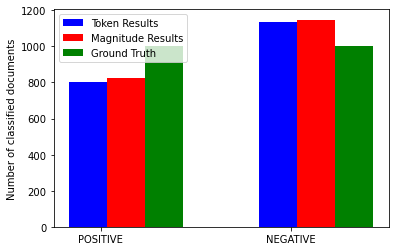

In [ ]:
# set height of bar 
neg = [neg_magnitude, neg_review_sentiment, neg_token] 
pos = [pos_magnitude, pos_review_sentiment, pos_token] 
   
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.2
   
# Make the plot 
bar1 = ax.bar(index, (pos_token, neg_token), bar_width,
                 color='b', 
                 label='Token Results')

bar2 = ax.bar(index + bar_width, (pos_magnitude, neg_magnitude), bar_width,
                 color='r', 
                 label='Magnitude Results')

bar3 = ax.bar(index + bar_width*2, (pos_review_sentiment, neg_review_sentiment), bar_width,
                color='g', 
                label='Ground Truth')
   
ax.set_ylabel("Number of classified documents")
ax.set_xticklabels(('POSITIVE', 'NEGATIVE'))
ax.set_xticks(index + bar_width / 3)
ax.legend()

## (Q1.3 Optional) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.


*Now with the current threshold it is the case that documents of shorter length will disproportionally often be classified as negative since there need to be at least 8 positive words present to be able to classify as positive review. To account for this imbalance, we could look at the positive/negative word split over all the reviews. In total there are 17.35% fewer negative words compared to positive in the corpus. Therefore in order to account for the imbalance, each positive word can each be counted as 1 and each negative word with 1.17355.*

In [ ]:
print('Total words in positive reviews:', total_pos_words)
print('Total words in negative reviews:', total_neg_words)

Total words in positive reviews: 78167
Total words in negative reviews: 64601


In [ ]:
1-(64601/78167)

0.1735514987142912

# Significance testing

Does using the magnitude improve the results? Oftentimes, answering such questions by simply comparing accuracy
scores is not enough. When dealing with natural language and human ratings, it is safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are due to mere chance.

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 

In this experiment, $q = 0.5$, so the formula simplifies to:
$$2\times 0.5^N\, \sum\limits_{i=0}^{k} \binom{N}{i}$$


We use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.


In [ ]:
from decimal import Decimal
from scipy.special import comb


def sign_test(results_1, results_2):
  """test for significance"""
  ties, plus, minus = 0, 0, 0

  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]==0: 
      plus += 1
    elif results_2[i]==0: 
      minus += 1
  
  n = (2*math.ceil(ties/2.0)) + plus + minus
  k = math.ceil(ties/2.0) + min(plus,minus)

  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
    summation += Decimal((comb(n,i,exact=True)))

  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(0.5)**Decimal(n))
  
  print("the difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation



In [ ]:
p_value = sign_test(token_results, magnitude_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.3477773685082211499213816862


### Using the Sign test

**From now on, report all differences between systems, as well as between system configurations, using the
sign test.**
    
You should report statistical test
results in an appropriate form. If there are several different methods
(i.e., systems) to compare, the Sign test can only be applied to pairs of them
at a time. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


# Naive Bayes (10pt)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q3.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**. 

In case 2, you could also set $P(c|\bar{f}) = 0$ for the class $c$ within which $f_i \in \bar{f}$ was not seen. One way to implement this in log space is to set $P(c|\bar{f}) = -\infty$. What would be the problem instead with skipping words only for one class in case 2? 

**Problem of not skipping unseen words for both classes in imbalanced dataset**: Since we are using log spaces which ranges between −∞ and 0, if we skip the word in the sentiment class where it does not appear then the reviews sentiments will be biased towards the sentiment class with fewer words since for the sentiment class where the word is not skipped another negative number (log(p)) is added to the sentiment score.
**Problem of setting 𝑃(𝑐|𝑓¯)=−∞ for unseen words**: This will have the effect that the log probabilities will be skewed towards the class with more words in the training set. Since we add up log probabilities , if in one class a word is unseen and then set to 𝑃(𝑐|𝑓¯)=−∞ then the classifier will automatically classify the review as the opposite sentiment class. 


#### (Q3.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
train_dict = {}
train_dict['POS'] = Counter()
train_dict['NEG'] = Counter()

for i in range(0,len(reviews)):
  if (reviews[i]['cv'] <= 899) & (reviews[i]['sentiment'] == 'POS'):
    for word in reviews[i]['content']:
      for token in word:
        word = token[0].lower()
        train_dict['POS'][word] += 1
  elif (reviews[i]['cv'] <= 899) & (reviews[i]['sentiment'] == 'NEG'):
    for word in reviews[i]['content']:
      for token in word:
        word = token[0].lower()
        train_dict['NEG'][word] += 1

In [ ]:
test_set = [i for i in reviews if i['cv'] > 899]
train_set = [i for i in reviews if i['cv'] <= 899]

In [ ]:
pos_val_train = sum(train_dict['POS'].values())
neg_val_train = sum(train_dict['NEG'].values())

In [ ]:
classification = []

for all_words in test_set: 
  prob_positive = 0
  prob_negative = 0
  for words in all_words['content']:
    for token in words:
      if token[0].lower() in train_dict['POS'] and token[0].lower() in train_dict['NEG']: 
        prob_positive += math.log(train_dict['POS'][token[0].lower()]/pos_val_train)
        prob_negative += math.log(train_dict['NEG'][token[0].lower()]/neg_val_train)
  if (prob_positive>prob_negative):
      classification.append('POS')
  else: 
      classification.append('NEG')

In [ ]:
def sentiment_analysis(test_set, classification): 
    
    review_sentiment = []
    for i in range(0,len(test_set)):
      review_sentiment.append(test_set[i]['sentiment'])
    review_sentiment = pd.DataFrame(review_sentiment, columns = ['review_sentiment'])
    classification = pd.DataFrame(classification, columns = ['classification'])
    
    review_sentiment_classification = pd.concat([review_sentiment, classification], axis=1, sort=False)
    review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['classification']==review_sentiment_classification['review_sentiment'], 
                                                 1, 0)
    results = review_sentiment_classification['classification_accuracy']
    return results                                         

In [ ]:
results=sentiment_analysis(test_set, classification)
accuracy = results.sum()/len(results)
print("Accuracy: %0.2f" % accuracy) 

Accuracy: 0.82


#### (Q3.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*9 out of 10 negative tweets are correctly guessed as negative, but the accuracy score for the positive reviews is only 56%. The imbalanced accuracy scores are caused the highly imbalanced data set (33105 words from positive reviews vs 8908 words from negative reviews). From the remaining words that are in both the positive and negative review vocabularies, their frequency is much higher in the negative reviews (since we divide by a much smaller vocabulary size) which leads to the fact that the log probability scores are skewed towards the negative class. In general if the training and test set is imbalanced the accuracy score is not a good performance evaluation metric anymore.* 

In [ ]:
train_dict_adj = {}
train_dict_adj["POS"] = Counter()
train_dict_adj["NEG"] = Counter()

for i in range(0,len(reviews)):
    if (reviews[i]['cv'] <= 899 and reviews[i]['sentiment'] == 'POS'):
        for word in reviews[i]["content"]:
            for token in word:
                word = token[0].lower()
                train_dict_adj["POS"][word] += 1
    if (reviews[i]['cv'] >= 0 and reviews[i]['cv'] <= 89 and reviews[i]['sentiment'] == 'NEG'):
        for word in reviews[i]["content"]:
            for token in word:
                word = token[0].lower()
                train_dict_adj["NEG"][word] += 1

In [ ]:
print('Total positive words:', len(train_dict_adj["POS"]), 
      'Total negative words:', len(train_dict_adj["NEG"]))

Total positive words: 33105 Total negative words: 8908


In [ ]:
pos_val_train_adj = sum(train_dict_adj["POS"].values())
neg_val_train_adj = sum(train_dict_adj["NEG"].values())

In [ ]:
test_set_adj = [i for i in test_set if ((i['sentiment'] == 'POS') or (i['sentiment'] == 'NEG' and 900 <= i['cv'] <= 909))]  

In [ ]:
classification = []

for all_words in test_set_adj: 
  prob_positive = 0
  prob_negative = 0
  for words in all_words['content']:
    for token in words:
      if token[0].lower() in train_dict_adj["POS"] and token[0].lower() in train_dict_adj["NEG"]:
        prob_positive += math.log(train_dict_adj["POS"][token[0].lower()]/pos_val_train_adj)
        prob_negative += math.log(train_dict_adj["NEG"][token[0].lower()]/neg_val_train_adj)
  if (prob_positive > prob_negative):
    classification.append('POS')
  else: 
    classification.append('NEG')

In [ ]:
results_naive_bayes_adj=sentiment_analysis(test_set_adj, classification)
accuracy = results_naive_bayes_adj.sum()/len(results_naive_bayes_adj)
print("Accuracy: %0.2f" % accuracy) 

Accuracy: 0.59


In [ ]:
review_sentiment = []
for i in range(0,len(test_set_adj)):
  review_sentiment.append(test_set_adj[i]['sentiment'])
review_sentiment = pd.DataFrame(review_sentiment, columns = ['review_sentiment'])
classification = pd.DataFrame(classification, columns = ['classification'])
    
review_sentiment_classification = pd.concat([review_sentiment, classification], axis=1, sort=False)
review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['classification']==review_sentiment_classification['review_sentiment'], 
                                                 1, 0)
#9 out of 10 negative tweets are classified correctly
review_sentiment_classification[review_sentiment_classification['review_sentiment'] == "NEG"]
#Accuracy score of positive reviews
review_sentiment_classification[review_sentiment_classification['review_sentiment'] == "POS"].classification_accuracy.sum()/100

0.56

## Smoothing (1.5pts)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
def get_vocab_length(data_set): 
    c = Counter()
    for review in data_set:
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                c[token.lower()] += 1
    return len(c)

In [ ]:
classification = []
vocab_size = get_vocab_length(train_set)

for all_words in test_set: 
  prob_positive = 0
  prob_negative = 0
  for words in all_words['content']:
    for token in words:
      prob_positive += math.log((train_dict["POS"][token[0].lower()] + 1)/(pos_val_train + vocab_size))
      prob_negative += math.log((train_dict["NEG"][token[0].lower()] + 1)/(neg_val_train + vocab_size))
  if (prob_positive>prob_negative):
      classification.append('POS')
  else: 
      classification.append('NEG')
    

In [ ]:
results_naive_bayes_smoothed=sentiment_analysis(test_set, classification)
accuracy = results_naive_bayes_smoothed.sum()/len(results_naive_bayes_smoothed)
print("Accuracy: %0.2f" % accuracy) 

Accuracy: 0.82


#### (Q3.5) Is the difference between non smoothed (Q3.2) and smoothed (Q3.4) statistically significant? (0.5pt)

In [ ]:
p_value = sign_test(results, results_naive_bayes_smoothed) 
print("p_value =", p_value)

the difference is not significant
p_value = 1.056348479009256422247245265


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q3.6) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
training_set=[]
cross_val_accuracies=[]
for j in range(10):
  split_train_data=[]
  split_test_data=[]
  #splitting data
  for cv, review in enumerate(reviews):
    if cv % 10 ==j:
      split_test_data.append(review)
    else:
      split_train_data.append(review)

  #used to determine the final training set
  training_set.append(split_train_data)

  #creating training dictionary with counted words
  train_dict = {}
  train_dict["POS"] = Counter()
  train_dict["NEG"] = Counter()
  

  for i in range(0,len(split_train_data)):
    if split_train_data[i]['sentiment'] == "POS":
      for lst in split_train_data[i]["content"]:
        for tokens in lst:
          word = tokens[0].lower()
          train_dict["POS"][word] += 1
    if split_train_data[i]['sentiment'] == "NEG":
      for lst in split_train_data[i]["content"]:
        for tokens in lst:
          word = tokens[0].lower()
          train_dict["NEG"][word] += 1

  pos_val_train = sum(train_dict["POS"].values())
  neg_val_train = sum(train_dict["NEG"].values())
  total_vocabulary_train = get_vocab_length(split_train_data)
  


  #use smooth naive bayes to predict classes
  classification = []
  for all_lsts in split_test_data:
    prob_positive = 0
    prob_negative = 0
    for lst in all_lsts['content']: 
      for tokens in lst:
        prob_positive += math.log((train_dict["POS"][tokens[0].lower()]+1)/(pos_val_train+total_vocabulary_train)) 
        prob_negative += math.log((train_dict["NEG"][tokens[0].lower()]+1)/(neg_val_train+total_vocabulary_train))
    if (prob_positive>prob_negative):
        classification.append("POS")
    else: 
        classification.append("NEG")

  #compare predictions with actual labels
  review_sentiment =[]
  for i in range(0,len(split_test_data)):
    review_sentiment.append(split_test_data[i]['sentiment'])
  review_sentiment = pd.DataFrame(review_sentiment, columns = ['review_sentiment'])
  classification = pd.DataFrame(classification, columns = ['classification'])
  review_sentiment_classification = pd.concat([review_sentiment, classification], axis=1, sort=False)
  review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['classification']==review_sentiment_classification['review_sentiment'], 
                                                 1, 0)
  cross_val_results = review_sentiment_classification['classification_accuracy']
  
  #computing accuracy
  cross_accuracy = cross_val_results.sum()/len(review_sentiment_classification)
  cross_val_accuracies.append(cross_accuracy)

print('Accuracies:',cross_val_accuracies)
print('Mean:',sum(cross_val_accuracies) / len(cross_val_accuracies))



Accuracies: [0.79, 0.835, 0.81, 0.83, 0.775, 0.85, 0.83, 0.78, 0.825, 0.845]
Mean: 0.817


#### (Q3.7) Write code to calculate and report the variance of the 10 accuracy scores, in addition to the final performance. You must not use a library, such as numpy. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [ ]:
# YOUR CODE HERE
m = sum(cross_val_accuracies) / len(cross_val_accuracies)
var = sum((xi - m) ** 2 for xi in cross_val_accuracies) / len(cross_val_accuracies)
print('Results:', cross_val_accuracies)    
print('Mean:', m)
print('Var:', var)

Results: [0.79, 0.835, 0.81, 0.83, 0.775, 0.85, 0.83, 0.78, 0.825, 0.845]
Mean: 0.817
Var: 0.0006509999999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.

You should also perform cross-validation. Concatenate the predictions from all folds to compute the significance.

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
#function for determining length of stemmed vocabulary
def stemmed_vocab_length(train_set):
  c=Counter()
  for review in train_set:
    for sentence in review['content']:
      for token, pos_tag in sentence:
        c[stemmer.stem(token.lower())] += 1
  return len(c)

In [ ]:
stemmed_training_set=[]
stemmed_accuracies=[]
for j in range(10):
  split_train_data=[]
  split_test_data=[]
  #splitting data
  for cv, review in enumerate(reviews):
    if cv % 10 ==j:
      split_test_data.append(review)
    else:
      split_train_data.append(review)

  stemmed_training_set.append(split_train_data)

  #creating training dictionary with counted words
  train_dict = {}
  train_dict["POS"] = Counter()
  train_dict["NEG"] = Counter()

  for i in range(0,len(split_train_data)):
    if split_train_data[i]['sentiment'] == "POS":
      for lst in split_train_data[i]["content"]:
        for tokens in lst:
          word = stemmer.stem(tokens[0].lower())
          train_dict["POS"][word] += 1
    if split_train_data[i]['sentiment'] == "NEG":
      for lst in split_train_data[i]["content"]:
        for tokens in lst:
          word = stemmer.stem(tokens[0].lower())
          train_dict["NEG"][word] += 1

  pos_val_train = sum(train_dict["POS"].values())
  neg_val_train = sum(train_dict["NEG"].values())
  stemmed_vocabulary = stemmed_vocab_length(split_train_data)
  

  #use smooth naive bayes to predict classes
  classification = []
  for all_lsts in split_test_data:
    prob_positive = 0
    prob_negative = 0
    for lst in all_lsts['content']: 
      for tokens in lst:
        prob_positive += math.log((train_dict["POS"][stemmer.stem(tokens[0].lower())]+1)/(pos_val_train+stemmed_vocabulary)) 
        prob_negative += math.log((train_dict["NEG"][ stemmer.stem(tokens[0].lower())]+1)/(neg_val_train+stemmed_vocabulary))
    if (prob_positive>prob_negative):
        classification.append("POS")
    else: 
        classification.append("NEG")

  #compare predictions with actual labels
  review_sentiment =[]
  for i in range(0,len(split_test_data)):
    review_sentiment.append(split_test_data[i]['sentiment'])
  review_sentiment = pd.DataFrame(review_sentiment, columns = ['review_sentiment'])
  classification = pd.DataFrame(classification, columns = ['classification'])
  review_sentiment_classification = pd.concat([review_sentiment, classification], axis=1, sort=False)
  review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['classification']==review_sentiment_classification['review_sentiment'], 
                                                 1, 0)
  stemmed_results = review_sentiment_classification['classification_accuracy']
  #computing accuracy
  stemmed_accuracy = stemmed_results.sum()/len(review_sentiment_classification)
  stemmed_accuracies.append(stemmed_accuracy)

print('Accuracies:',stemmed_accuracies)
print('Mean:',sum(stemmed_accuracies) / len(stemmed_accuracies))


Accuracies: [0.78, 0.84, 0.81, 0.85, 0.775, 0.835, 0.81, 0.775, 0.83, 0.84]
Mean: 0.8145000000000001


#### (Q3.9): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (1pt)


In [ ]:
pvalue=sign_test(cross_val_accuracies, stemmed_accuracies)
print('P value:', pvalue)

the difference is not significant
P value: 1.50


#### (Q3.10) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# when using stemming the total number of features shrinks
print('Size of standard vocabulary:', get_vocab_length(training_set[0]))
print('Size of stemmed vocabulary:', stemmed_vocab_length(stemmed_training_set[0]))

Size of standard vocabulary: 45329
Size of stemmed vocabulary: 32371


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-gram** features. 






#### (Q3.11) Retrain your classifier from (Q3.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and statistical significances (in comparison to the experiment at (Q3.6) for all 10 folds, and between the new systems). You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
cross_val_accuracies_unigram_bigram =[]
vocab_length_uniqram_bigram = []

for j in range(10):
    split_train_data=[]
    split_test_data=[]
  #splitting data
    for cv, review in enumerate(reviews):
        if cv % 10 ==j:
            split_test_data.append(review)
        else:
            split_train_data.append(review)

  #creating training dictionary with counted words
    dic = {}
    dic["POS"] = []
    dic["NEG"] = []
    for i in range(0, len(split_train_data)): 
      sentiment = split_train_data[i]["sentiment"]
      for sentence in split_train_data[i]["content"]: 
        for word in sentence: 
          dic[sentiment].append(word[0].lower())

    dic_grams = {}
    dic_grams["POS"] = []
    dic_grams["NEG"] = []
    dic_grams["POS"] = list(nltk.ngrams(dic["POS"], n = 2)) + list(nltk.ngrams(dic["POS"], n = 1))
    dic_grams["NEG"] = list(nltk.ngrams(dic["NEG"], n = 2)) + list(nltk.ngrams(dic["NEG"], n = 1))

    train_dict = {}
    train_dict['POS'] = Counter()
    train_dict['NEG'] = Counter()

    for i in range(0,len(dic_grams['POS'])):
      word = dic_grams['POS'][i]
      train_dict['POS'][word] += 1

    for i in range(0,len(dic_grams['NEG'])): 
      word = dic_grams['NEG'][i]
      train_dict['NEG'][word] += 1  

    pos_val_train = sum(train_dict["POS"].values())
    neg_val_train = sum(train_dict["NEG"].values())
    total_words = list(nltk.ngrams(dic["POS"], n = 2)) + list(nltk.ngrams(dic["POS"], n = 1)) + list(nltk.ngrams(dic["NEG"], n = 2)) + list(nltk.ngrams(dic["NEG"], n = 1))
    vocabulary_length = len(set(total_words))

    classification = []
 

    for all_words in split_test_data:
      prob_positive = 0
      prob_negative = 0
      for sentence in all_words['content']:
        words = [word for (word, pos_tag) in sentence]
        words = [x.lower() for x in words]
        list_grams = list(nltk.ngrams(words, n = 2)) + list(nltk.ngrams(words, n = 1))
        for i in range(0, len(list_grams)): 
          prob_positive += math.log((train_dict["POS"][list_grams[i]] + 1) / (pos_val_train + vocabulary_length))
          prob_negative += math.log((train_dict["NEG"][list_grams[i]] + 1) / (neg_val_train + vocabulary_length))
      if (prob_positive>prob_negative):
          classification.append('POS')
      else: 
          classification.append('NEG')

    #compare predictions with actual labels
    results = sentiment_analysis(split_test_data, classification)
    accuracy = results.sum()/len(results)
    cross_val_accuracies_unigram_bigram.append(accuracy)
    vocab_length_uniqram_bigram.append(vocabulary_length)

print('Accuracies:',cross_val_accuracies_unigram_bigram)
print('Mean:',sum(cross_val_accuracies_unigram_bigram) / len(cross_val_accuracies_unigram_bigram))

Accuracies: [0.8, 0.87, 0.83, 0.87, 0.81, 0.87, 0.825, 0.84, 0.86, 0.845]
Mean: 0.842


In [ ]:
cross_val_accuracies_unigram_bigram_trigram =[]
vocab_length_uniqram_bigram_trigram = []
for j in range(10):
    split_train_data=[]
    split_test_data=[]
  #splitting data
    for cv, review in enumerate(reviews):
        if cv % 10 ==j:
            split_test_data.append(review)
        else:
            split_train_data.append(review)

  #creating training dictionary with counted words
    dic = {}
    dic["POS"] = []
    dic["NEG"] = []
    for i in range(0, len(split_train_data)): 
        sentiment = split_train_data[i]["sentiment"]
        for sentence in split_train_data[i]["content"]: 
            for word in sentence: 
                dic[sentiment].append(word[0].lower())

    dic_grams = {}
    dic_grams["POS"] = []
    dic_grams["NEG"] = []
    dic_grams["POS"] = list(nltk.ngrams(dic["POS"], n = 3)) + list(nltk.ngrams(dic["POS"], n = 2)) + list(nltk.ngrams(dic["POS"], n = 1))
    dic_grams["NEG"] = list(nltk.ngrams(dic["NEG"], n = 3)) + list(nltk.ngrams(dic["NEG"], n = 2)) + list(nltk.ngrams(dic["POS"], n = 1))

    train_dict = {}
    train_dict['POS'] = Counter()
    train_dict['NEG'] = Counter()

    for i in range(0,len(dic_grams['POS'])):
        word = dic_grams['POS'][i]
        train_dict['POS'][word] += 1

    for i in range(0,len(dic_grams['NEG'])): 
        word = dic_grams['NEG'][i]
        train_dict['NEG'][word] += 1  

    pos_val_train = sum(train_dict["POS"].values())
    neg_val_train = sum(train_dict["NEG"].values())
    total_words = list(nltk.ngrams(dic["POS"], n = 3)) + list(nltk.ngrams(dic["POS"], n = 2)) + list(nltk.ngrams(dic["POS"], n = 1)) + list(nltk.ngrams(dic["NEG"], n = 3)) + list(nltk.ngrams(dic["NEG"], n = 2)) + list(nltk.ngrams(dic["NEG"], n = 1))
    vocabulary_length = len(set(total_words))

    classification = []

    for all_words in split_test_data:
      prob_positive = 0
      prob_negative = 0
      for sentence in all_words['content']:
        words = [word for (word, pos_tag) in sentence]
        words = [x.lower() for x in words]
        list_grams = list(nltk.ngrams(words, n = 3)) + list(nltk.ngrams(words, n = 2)) + list(nltk.ngrams(words, n = 1))
        for i in range(0, len(list_grams)): 
          prob_positive += math.log((train_dict["POS"][list_grams[i]] + 1) / (pos_val_train + vocabulary_length))
          prob_negative += math.log((train_dict["NEG"][list_grams[i]] + 1) / (neg_val_train + vocabulary_length))
      if (prob_positive>prob_negative):
          classification.append('POS')
      else: 
          classification.append('NEG')

    #compare predictions with actual labels
    results = sentiment_analysis(split_test_data, classification)
    accuracy = results.sum()/len(results)
    cross_val_accuracies_unigram_bigram_trigram.append(accuracy)
    vocab_length_uniqram_bigram_trigram.append(vocabulary_length)

print('Accuracies:',cross_val_accuracies_unigram_bigram_trigram)
print('Mean:',sum(cross_val_accuracies_unigram_bigram_trigram) / len(cross_val_accuracies_unigram_bigram_trigram))

Accuracies: [0.8, 0.835, 0.82, 0.86, 0.75, 0.86, 0.83, 0.845, 0.855, 0.825]
Mean: 0.828


In [ ]:
#comparison with smoothed Naive bayes model and unigram+bigram model
pvalue=sign_test(cross_val_accuracies, cross_val_accuracies_unigram_bigram)
print('P value:', pvalue)

the difference is not significant
P value: 1.50


In [ ]:
#comparison with smoothed Naive bayes model and unigram+bigram+trigram model
pvalue=sign_test(cross_val_accuracies, cross_val_accuracies_unigram_bigram_trigram)
print('P value:', pvalue)

the difference is not significant
P value: 1.50


Q3.12: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q3.10)?

Use the held-out training set once again for this.

*When using unigrams+bigrams, the BoW model has to take in account 472932 features, which compared to the standard vocabulary computed in Q3.10 (45329), represents a tenfold increase.*
*When using unigrams+bigrams+trigrams, the model has to consider 1426350 features, which again, compared to the standard vocabulary represents a thirty-fold increase.*
*The unigrams+bigrams+trigrams model has three times more features than the unigrams+bigrams, thus, theoretically, we would expect the number of features to increase approximately linearly.* 

In [ ]:
print("Size of Unigram+Bigram Vocabulary:", vocab_length_uniqram_bigram[0])
print("Size of Unigram+Bigram+Trigram Vocabulary:", vocab_length_uniqram_bigram_trigram[0])

Size of Unigram+Bigram Vocabulary: 472932
Size of Unigram+Bigram+Trigram Vocabulary: 1426350


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q4.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing from (Q3.6) and report the numbers.
Perform cross-validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [ ]:
def svm_data(reviews):
    features = []
    labels = []
    for review in reviews:
      sentiment = 1 if review['sentiment'] == 'POS' else -1
      words_pre_pre = list(itertools.chain(*review['content']))
      words_pre = list(itertools.chain(*words_pre_pre))
      words = words_pre[::2]
      words = " ".join(words)
      words = words.lower()
      labels.append(sentiment)
      features.append(words)
    return features, labels

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer


cross_val_svm=[]
#initializing vectorizer
vectorizer=CountVectorizer()
svc=LinearSVC()

for j in range(10):
  split_test_data=[]
  split_train_data=[]
  #splitting data 
  for cv, review in enumerate(reviews):
    if cv % 10 == j:
      split_test_data.append(review)
    else:
      split_train_data.append(review)
  
  #getting geatures and labels for both training and testing sets
  train_features, train_labels=svm_data(split_train_data)
  test_features,test_labels=svm_data(split_test_data)

  #vectorizing features
  train_features_vectorized=vectorizer.fit_transform(train_features)
  test_features_vectorized=vectorizer.transform(test_features)

  #training the model
  model = svc.fit(train_features_vectorized, train_labels)
  #predicting with the trained model
  prediction = model.predict(test_features_vectorized)
  
  #compare predictions with test labels
  predictions = pd.DataFrame(prediction, columns = ['predictions'])
  actual=pd.DataFrame(test_labels, columns = ['actual'])
  review_sentiment_classification = pd.concat([predictions, actual], axis=1, sort=False)
  review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['predictions']==review_sentiment_classification['actual'], 
                                                 1, 0)
  results = review_sentiment_classification['classification_accuracy']
  #calculate accuracy
  svm_accuracy = results.sum()/len(results)
  cross_val_svm.append(svm_accuracy)

print('Accuracies:',cross_val_svm)
print('Mean:',sum(cross_val_svm) / len(cross_val_svm))



/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear f

Accuracies: [0.815, 0.815, 0.805, 0.855, 0.845, 0.835, 0.865, 0.84, 0.855, 0.81]
Mean: 0.834


In [ ]:
pvalue=sign_test(cross_val_accuracies, cross_val_svm)
print('p-value=', pvalue)

the difference is not significant
p-value= 2


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Perform cross-validation and concatenate the predictions from all folds to compute the significance. Are the results significant? *Why?*  (1pt)


In [ ]:
def svm_data_pos(reviews):
    features = []
    labels = []
    for review in reviews:
        sentiment = 1 if review['sentiment'] == 'POS' else -1
        content = review['content']
        words_pre = list(itertools.chain(*content))
        list_empty = []
        for token, pos in words_pre: 
            words = "".join([token,pos])
            list_empty.append(words)
        list_empty = ' '.join(list_empty)
        list_empty = list_empty.lower()
        features.append(list_empty)
        labels.append(sentiment)
    return features, labels

In [ ]:
cross_val_svm_pos=[]

for j in range(10):
  split_test_data=[]
  split_train_data=[]
  #splitting data 
  for cv, review in enumerate(reviews):
    if cv % 10 == j:
      split_test_data.append(review)
    else:
      split_train_data.append(review)
  
  #getting geatures and labels for both training and testing sets
  train_features, train_labels=svm_data_pos(split_train_data)
  test_features,test_labels=svm_data_pos(split_test_data)

  #vectorizing features
  train_features_vectorized=vectorizer.fit_transform(train_features)
  test_features_vectorized=vectorizer.transform(test_features)

  #training the model
  model = svc.fit(train_features_vectorized, train_labels)
  #predicting with the trained model
  prediction = model.predict(test_features_vectorized)
  
  #compare predictions with test labels
  predictions = pd.DataFrame(prediction, columns = ['predictions'])
  actual=pd.DataFrame(test_labels, columns = ['actual'])
  review_sentiment_classification = pd.concat([predictions, actual], axis=1, sort=False)
  review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['predictions']==review_sentiment_classification['actual'], 
                                                 1, 0)
  results = review_sentiment_classification['classification_accuracy']
  #calculate accuracy
  svm_accuracy = results.sum()/len(results)
  cross_val_svm_pos.append(svm_accuracy)

print('Accuracies:',cross_val_svm_pos)
print('Mean:',sum(cross_val_svm_pos) / len(cross_val_svm_pos))



/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear f

Accuracies: [0.815, 0.825, 0.835, 0.845, 0.835, 0.835, 0.855, 0.86, 0.855, 0.83]
Mean: 0.8389999999999999


In [ ]:
pvalue=sign_test(cross_val_accuracies,cross_val_svm_pos)
print('p-value=', pvalue)

the difference is not significant
p-value= 2


 *When using the POS tag, we obtain just a slight improvement in accuracy for some folds and a slightly higher value for the mean of accuracies. However, these differences are not significant as showed when performing the sign test and we can conclude that both the model with POS and without are equally good. This experiment also confirms the findings of  Pang et al. (2002),that the effect of POS tags information is more of a 'wash' . An explanation could be that not all POS tag carry relevant information for the classifier.*
  
  

#### (Q4.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Perform cross-validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? *Why?* (1pt)

In [ ]:
tags_to_keep = [
  # Nouns
  'NN', 'NNS', 'NNP', 'NNPS',
  # Verbs
  'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD',
  # Adjectives
  'JJ', 'JJR', 'JJS',
  # Adverbs
  'RB', 'RBR', 'RBS', 'RP'
]


def svm_data_pos_adj(reviews):
    features = []
    labels = []
    for review in reviews:
      sentiment = 1 if review['sentiment'] == 'POS' else -1
      content = review['content']
      words_pre = list(itertools.chain(*content))
      list_empty = []
      for token, pos in words_pre: 
        if pos in tags_to_keep:
          words = "".join([token,pos])
          list_empty.append(words)
      list_empty = ' '.join(list_empty)
      list_empty = list_empty.lower()
      features.append(list_empty)
      labels.append(sentiment)
    return features, labels


In [ ]:
cross_val_svm_pos_adj=[]

for j in range(10):
  split_test_data=[]
  split_train_data=[]
  #splitting data 
  for cv, review in enumerate(reviews):
    if cv % 10 == j:
      split_test_data.append(review)
    else:
      split_train_data.append(review)
  
  #getting geatures and labels for both training and testing sets
  train_features, train_labels=svm_data_pos_adj(split_train_data)
  test_features,test_labels=svm_data_pos_adj(split_test_data)

  #vectorizing features
  train_features_vectorized=vectorizer.fit_transform(train_features)
  test_features_vectorized=vectorizer.transform(test_features)

  #training the model
  model = svc.fit(train_features_vectorized, train_labels)
  #predicting with the trained model
  prediction = model.predict(test_features_vectorized)
  
  #compare predictions with test labels
  predictions = pd.DataFrame(prediction, columns = ['predictions'])
  actual=pd.DataFrame(test_labels, columns = ['actual'])
  review_sentiment_classification = pd.concat([predictions, actual], axis=1, sort=False)
  review_sentiment_classification['classification_accuracy'] = np.where(review_sentiment_classification['predictions']==review_sentiment_classification['actual'], 
                                                 1, 0)
  results = review_sentiment_classification['classification_accuracy']
  #calculate accuracy
  svm_accuracy = results.sum()/len(results)
  cross_val_svm_pos_adj.append(svm_accuracy)

print('Accuracies:',cross_val_svm_pos_adj)
print('Mean:',sum(cross_val_svm_pos_adj) / len(cross_val_svm_pos_adj))



/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreaprenner/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear f

Accuracies: [0.825, 0.84, 0.835, 0.845, 0.855, 0.83, 0.895, 0.87, 0.855, 0.83]
Mean: 0.8479999999999999


In [ ]:
pvalue=sign_test(cross_val_accuracies,cross_val_svm_pos_adj)
print('p-value=', pvalue)

the difference is not significant
p-value= 2


*Assuming that some POS tags carry more information than others, we have discarded all closed class words keeping only nouns, verbs, adjectives, and adverbs. The results are mixed. We get slight improvements for some of the folds, and lower accuracies for others. On average the mean accuracy is 0.8479 which is higher than from the other two SVM models. This may result from the fact that nouns, verbs, adjectives, and adverbs contain the greatest sentiment information compared to other words in the corpus.*

# (Q5) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*This practical gave us the possibility to experiment with various techniques in sentiment analysis. Based on our experiments, we have made the following conclusions:*

*Machine Learning based classification techniques like Naïve Bayes and SVM, perform better than lexicon-based classification techniques. A reason for that could be that these methods are able to  solve the issue that we can encounter with lexicon based analysis when trying to capture specific meanings of a certain word or meanings of words which might be missing in the lexicon( [Yousefpour et al.](http://isisell.com/freeupload/2017860611-31420-t.pdf)).*

*Our implementation of the non-smoothed Naïve Bayes has given us the same results as when applying Laplace smoothing to Naïve Bayes, even though we expected an increase in accuracy by applying Naïve Bayes with smoothing.  One approach to further improve the Naïve Bayes classifiers is to remove stopwords or punctuations from the training and test set since these features do not provide any sentiment insight but might lead to problems for imbalanced datasets. The bias in imbalanced datasets is caused because we divide by an unequal size of positive or negative words resulting in a higher probability for the stopwords/punctuation within the class with smaller word size.*

*The SVM models have had a slightly better accuracy than the smoothed Naïve Bayes, however, this difference has not been statistically significant. The SVM model with POS features has also had some small increase in accuracy. Using only words with ‘nouns, verbs, adjectives, adverbs’ POS features the accuracy even improved further. We have not performed any hyperparameter tuning, but we can argue that with that our result would have been more robust. An SVM model combined with POS feature and n-grams as well, where stopwords  has been removed and hyperparameter have been tuned, might perform significantly better.*

*Stemming seems to be a good technique for dimensionality reduction as it helped us shrink the size of our vocabulary. In our case, it didn’t improve accuracy, but it could be a very useful method for large datasets.*
 
*Regarding the features used in the analysis, we have seen that when using n-grams our performance has improved for each fold. However, when we added the trigrams to the model as well, we had a taste of the dimensionality ‘curse’- the model took longer to run and the accuracy has reduced compared to the unigram+bigram model. Overall, we concluded that n-grams can be useful features for our model as they capture the existing dependencies between words.*





# Submission 


In [ ]:
# Write your names and student numbers here:
# Andrea Prenner #13325973
# Iuliana-Laurentia Rosca #13243705

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 